# Ensemble Methods - Bagging 
## Import Libraries

In [1]:
import joblib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model

from sklearn.metrics import mean_squared_error, mean_absolute_error

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pd.set_option('display.max_columns', 500)

2022-09-16 11:23:51.756371: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-16 11:23:51.761548: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-16 11:23:51.761560: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from goat3.pipeline import PandasPipeline, ColumnsSelector
from goat3.validation import plot_adequation, plot_residuals, plot_confidence, plot_confidence_v2, plot_cumulative
from goat3.metamodel import KerasRegressorGoat, BaggingRegressorGoat
from goat3 import create_fully_connected
from goat3.validation._validation import table_results

## Load the Dataset - RR Dense 

In [3]:
data = pd.read_excel("../../../Data/dense_data.xlsx")

In [4]:
data.head()

,Unnamed: 0,RRc Rim_Width,RRc IP,RRc Load (daN),C+F,ETM,HBT,EBT_max,HBJ,EBJ_max,PNC_J_THICK,MNT1,ANT1_cured,TEV_BDR,TEV_Shoulder,HSRE_0%,HSRE_100%,DROOP_100%,SRE_ENDy,SRE_ENDz,Curing_Rim,Ny,Mz,Jy,Jz,EQy,CPJy,CPJz,Zy,Zz,NC_Cal_THICK,NC_Cable_DENS,TRINGLE_Metal_Section,NST_Cable_PACE,NST_Cal_THICK,KM_KM2_MA10,KM_KM2_MA100,KM_KM2_TanDelta,KM_KM2_G*,FE_G*_10%_ 23C_10Hz,FE_Gsec_10%_23C_10Hz,FE_TanDelta_max_23C_10Hz,DDPC_Type,RRc Method,Usine,COUCAR,LOI_FRETTAGE,BAZ_Type,Nb_NC,GI,BT,BJ,PT,PS,CJK,Sre_ID,SC_KM1,NC_Cable_CONST,NC_Cal_ML,TRINGLE_Type,NST_Cal_ML,NST_Cable_DIAM,NSF_Cal_ML,NSF_Cable_MAT,RRc MIRRI,FE,KM_KM2,NC,NSF,NST,TRINGLE
0,8459,4.5,210,304,11.0,14.5,33,3.2,0,0.0,5.9,61,26.0,24.27,20.35,8.0,5.07761,6.59473,72.72,256.90,5.91,58.21,278.5,74.90,254.29,83.08,82.72,212.81,81.19,199.4,0.45,80,11.696542,1.20,0.45,4.5,1.6,0.343857,2.167995,1.17,0.15,0.13,SI,BN75,DUN,Flat,P11-03,NSF_DEB,1,ML02353,ML20967,No_BJ,ML21588,ML19940,Without_CJK,E_9087,Full_KM,334,ML24257,TTAm,ML17596,30,ML24680,N,10.136667,ML19086,ML25521,CM11370,BM11120,NK23299,MT01602
1,43752,5.0,210,343,7.5,14.8,30,3.5,0,0.0,6.8,66,25.0,24.20,16.70,8.0,6.00000,5.80000,76.60,264.90,6.00,62.50,286.5,79.10,262.30,87.81,82.20,199.40,82.20,199.4,0.46,98,11.581167,1.20,0.45,5.7,2.1,0.340000,2.800000,1.18,0.19,0.16,SI,KT-B-12-9,PPD,Flat,P11-03,NSF_DEB,1,ML06066,ML17077,No_BJ,ML17214,ML17247,Without_CJK,E_9087,Full_KM,220,ML17618,TPC,ML17436,30,ML17033,N,9.960000,ML17407,ML17467,CM11563,BM10562,NK22266,MP91350
2,13568,5.0,210,343,9.0,12.9,33,2.9,0,0.0,5.0,68,25.0,26.55,18.98,7.6,5.37998,7.25013,79.28,261.14,6.30,62.40,283.5,82.49,257.99,92.28,84.99,199.40,84.99,199.4,0.40,104,11.696542,1.25,0.45,4.9,1.7,0.320000,2.200000,1.17,0.15,0.13,SI,BN51,BKR,Flat,P11-03,NSF_ARAS,1,ML02353,ML20967,No_BJ,ML21588,ML24335,Without_CJK,E_1749,Full_KM,144,ML24257,TTAm,ML24335,26,ML24680,N,8.336667,ML19086,ML25255,CM10895,BM11119,NK21847,MT01602
3,61759,5.0,210,343,9.0,12.9,33,3.2,0,0.0,5.0,68,26.0,26.55,18.98,7.6,5.37998,7.25013,79.28,261.14,6.30,62.40,283.5,82.49,257.99,92.28,84.99,199.40,84.99,199.4,0.40,104,11.696542,1.20,0.45,4.9,1.7,0.320000,2.200000,1.17,0.15,0.13,SI,BN75,DUN,Flat,P11-03,NSF_ARAS,1,ML02353,ML20967,No_BJ,ML21588,ML24335,Without_CJK,E_1749,ML25415,144,ML24257,TTAm,ML24335,30,ML24680,N,8.470000,ML19086,ML25415,CM10895,BM11119,NK23137,MT01602
4,65378,5.0,210,343,9.0,14.0,58,3.0,0,0.0,5.0,67,26.0,24.21,19.53,8.2,5.27779,6.59016,78.10,264.65,6.30,63.00,286.2,80.59,261.99,92.20,83.99,199.40,83.99,199.4,0.45,80,11.696542,1.25,0.45,6.2,2.1,0.354917,2.852401,1.17,0.15,0.13,MC,BN75,DUN,Flat,P11-03,NSF_DEB,1,ML02353,ML20967,No_BJ,ML21588,ML19940,Without_CJK,E_9087,ML24292,334,ML24257,TTAm,ML22500,26,ML24680,N,9.790000,ML19086,ML24292,CM11370,BM11119,NK20921,MT01602


## Drop Duplicates

In [5]:
# Split data into X, y sets
y = data["RRc MIRRI"]
X = data.drop(["Unnamed: 0", "RRc MIRRI", "Sre_ID"], axis=1)

## Preprocessing

In [6]:
# Create the preprocessing pipelines for numerical data.
numerical_transformer = PandasPipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant',fill_value=0,verbose=1)),
        ('scaler', StandardScaler())])

# Create the preprocessing pipelines for categorical data.
categorical_transformer = PandasPipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing',verbose=1)),
    ('onehot', OneHotEncoder(categories='auto',sparse=False,handle_unknown='ignore'))])

# Combine all elements of preprocessor
preprocessor = PandasPipeline(steps=[
        ("union", FeatureUnion(transformer_list=[
    ('numerical',PandasPipeline(steps=[
        ('get_num_cols',ColumnsSelector(col_types=[np.float64, np.int64], coerce='numeric')),
        ('transformer',numerical_transformer)])),
    ('categorical',PandasPipeline(steps=[
        ('get_cat_cols',ColumnsSelector(col_types=[object], coerce='object')),
        ('transformer',categorical_transformer)]))
    ])) 
])

In [7]:
# Split in train, val and generalization

np.random.seed(0)
train_index, test_index = train_test_split(X.index, train_size=0.8)

X_train = X.loc[train_index]
y_train = y.loc[train_index]
X_test = X.loc[test_index]
y_test = y.loc[test_index]

## Model

In [8]:
def get_base_model(units=1):
    model = Sequential()
    model.add(Dense(100, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(units, activation=None))
    model.compile(loss="mse", optimizer=Adam(0.001))
    return model

## Methods

### Boostrap

In [9]:
network = KerasRegressorGoat(get_base_model,
                             epochs=50,
                             verbose=0,
                             batch_size=128)

regressor = TransformedTargetRegressor(
    regressor=network,
    transformer=StandardScaler())

bagging = BaggingRegressorGoat(regressor, n_estimators=30, verbose=0, n_jobs=10, bootstrap=True)

model = PandasPipeline([("preprocessing", preprocessor), ("model", bagging)])

In [11]:
%%time
model.fit(X_train, y_train);

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/NAS/USERS/e044432/.local/lib/python3.8/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
2022-09-16 11:25:30.520701: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-16 11:25:30.520696: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numeri

CPU times: user 3.25 s, sys: 500 ms, total: 3.75 s
Wall time: 1min 8s


PandasPipeline(steps=[('preprocessing',
                       PandasPipeline(steps=[('union',
                                              FeatureUnion(transformer_list=[('numerical',
                                                                              PandasPipeline(steps=[('get_num_cols',
                                                                                                     ColumnsSelector(coerce='numeric',
                                                                                                                     col_types=[<class 'numpy.float64'>,
                                                                                                                                <class 'numpy.int64'>])),
                                                                                                    ('transformer',
                                                                                                     PandasPipeline(steps=[('imputer',
                                                                                                                            SimpleImputer(fill_value=0,
                                                                                                                                          strategy='constant',
                                                                                                                                          verbose=1)),...
                                                                                                     PandasPipeline(steps=[('imputer',
                                                                                                                            SimpleImputer(fill_value='missing',
                                                                                                                                          strategy='constant',
                                                                                                                                          verbose=1)),
                                                                                                                           ('onehot',
                                                                                                                            OneHotEncoder(handle_unknown='ignore',
                                                                                                                                          sparse=False))]))]))]))])),
                      ('model',
                       BaggingRegressorGoat(base_estimator=TransformedTargetRegressor(regressor=<goat3.metamodel._model.KerasRegressorGoat object at 0x7f4c402ae7f0>,
                                                                                      transformer=StandardScaler()),
                                            n_estimators=30, n_jobs=10))])

In [11]:
y_train_pred, y_train_q05, y_train_q95 = model.predict(X_train, aggregation=["median", "q05", "q95"], n_jobs=1)
y_test_pred, y_test_q05, y_test_q95 = model.predict(X_test, aggregation=["median", "q05", "q95"], n_jobs=1)

In [16]:
# get the variance
y_test_pred, stds_test = model.predict(X_test, aggregation=["median", "std"], n_jobs=1)

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/goat3/validation/_validation.py:1031: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax.set_ylim(y_lim)
/NAS/USERS/e044432/.local/lib/python3.8/site-packages/goat3/validation/_validation.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  item.set_height(item.get_height()*0.15*(height/cont_height))
/NAS/USERS/e044432/.local/lib/python3.8/site-packages/goat3/validation/_validation.py:1020: RuntimeWarning: invalid value encountered in double_scalars
  item.set_height(item.get_height()*0.15*(height/cont_height))


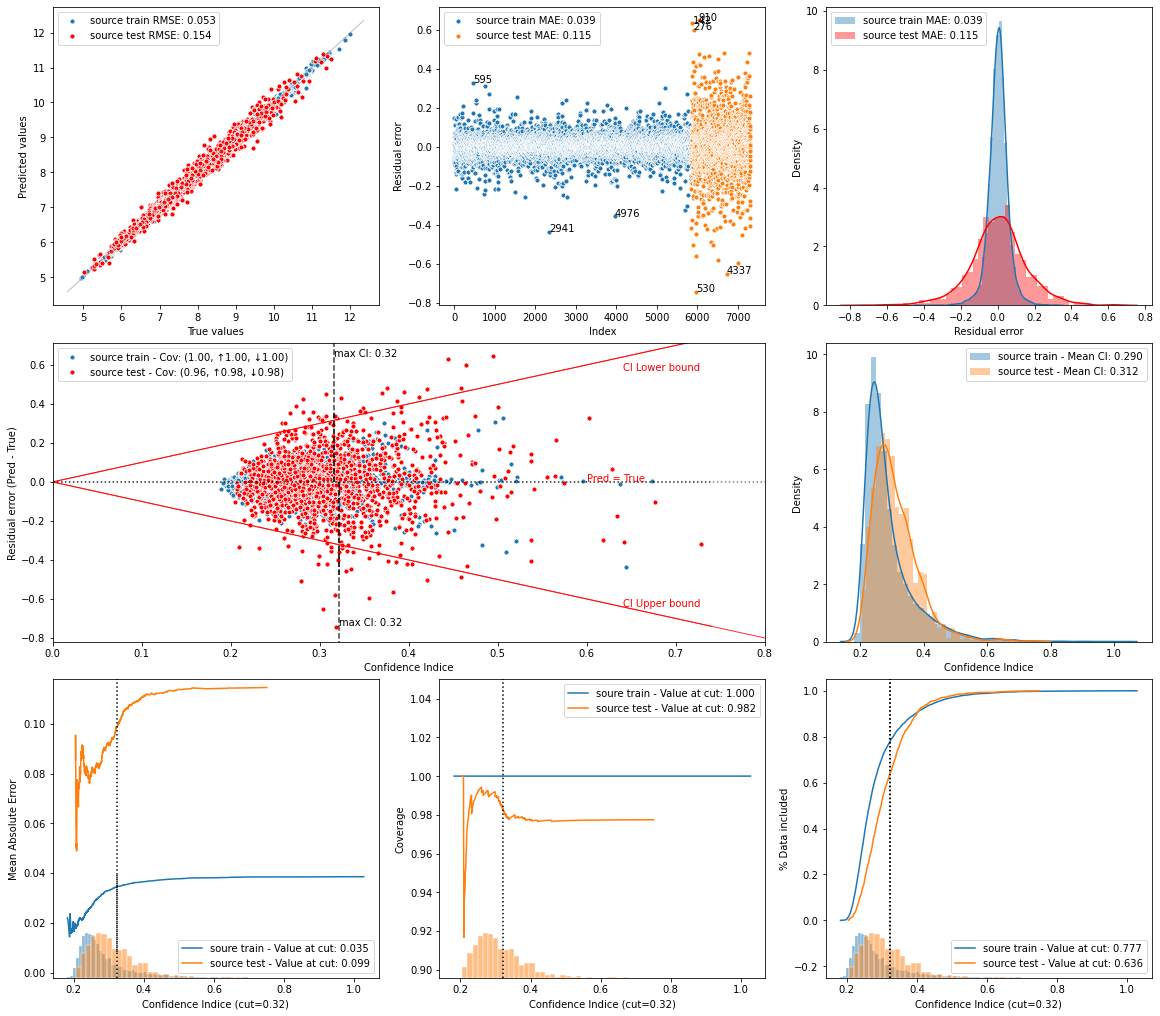

In [14]:
warnings.simplefilter(action='ignore', category=FutureWarning)

fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0]); ax2 = fig.add_subplot(gs[0, 1]); ax3 = fig.add_subplot(gs[0, 2]);
ax4 = fig.add_subplot(gs[1, 0:2]); ax5 = fig.add_subplot(gs[1, 2]);
ax6 = fig.add_subplot(gs[2, 0]); ax7 = fig.add_subplot(gs[2, 1]); ax8 = fig.add_subplot(gs[2, 2]);

plot_adequation(y_train, y_train_pred, label='source train', ax=ax1, score='RMSE')
plot_adequation(y_test, y_test_pred, label='source test', ax=ax1,color='red', plot_line=False, score='RMSE')

plot_residuals(y_train, y_train_pred, label='source train',ax=ax2,score='MAE',show_outliers=3)
plot_residuals(y_test, y_test_pred, index=len(y_train), label='source test', ax=ax2,score='MAE',show_outliers=5)

plot_residuals(y_train, y_train_pred, kind='hist', label='source train', ax=ax3, score='MAE')
plot_residuals(y_test, y_test_pred, kind='hist', label='source test', color='red', ax=ax3, score='MAE')

cut = model[-1].thresholds_

plot_confidence_v2(y_train, y_train_pred, y_train_q05, y_train_q95, label='source train', ax=ax4, cut=cut)
plot_confidence_v2(y_test, y_test_pred, y_test_q05, y_test_q95, label='source test',color='red', ax=ax4, cut=cut)

plot_residuals( y_train_pred, y_train_q95, kind='hist', label='source train - Mean CI:', score=mean_absolute_error, ax=ax5)
plot_residuals(y_test_pred, y_test_q95, kind='hist', label='source test - Mean CI:', ax=ax5, score=mean_absolute_error)
ax5.set_xlabel("Confidence Indice")

plot_cumulative((y_train_q95-y_train_pred), np.abs(y_train-y_train_pred), name="Mean Absolute Error", cut=cut[-1], label="soure train", ax=ax6)
plot_cumulative((y_test_q95-y_test_pred), np.abs(y_test-y_test_pred), ax=ax6, name="Mean Absolute Error", cut=cut[-1], label="source test")

plot_cumulative((y_train_q95-y_train_pred), (y_train<=y_train_q95), name="Coverage", cut=cut[-1], label="soure train", ax=ax7)
plot_cumulative((y_test_q95-y_test_pred), (y_test<=y_test_q95), ax=ax7, name="Coverage", cut=cut[-1], label="source test")

plot_cumulative((y_train_q95-y_train_pred), np.ones(len(y_train_q95)), name="% Data included", normalize=False, cut=cut[-1], label="soure train", ax=ax8)
plot_cumulative((y_test_q95-y_test_pred), np.ones(len(y_test_q95)), name="% Data included", normalize=False, cut=cut[-1], label="source test", ax=ax8)

plt.show()

## Calibration

In [15]:
import uncertainty_toolbox as uct

Check the calibration Curve on test data

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

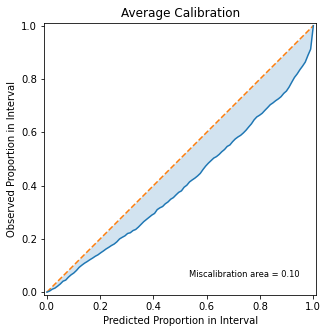

In [17]:
uct.viz.plot_calibration(np.array(y_test_pred),  np.array(stds_test) , np.array(y_test))

In [20]:
# Fit a Calibrator using the standard deviations.
recalibrator = uct.recalibration.get_std_recalibrator(np.array(y_test_pred), np.array(stds_test), np.array(y_test), criterion='ma_cal')
new_stds = recalibrator(np.array(stds_test))

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

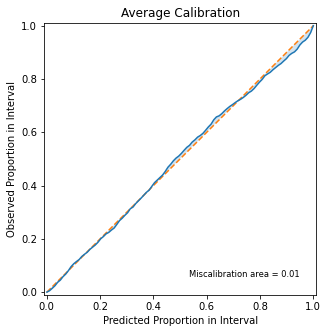

In [21]:
uct.viz.plot_calibration(np.array(y_test_pred),  np.array(new_stds) , np.array(y_test))

### Table

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

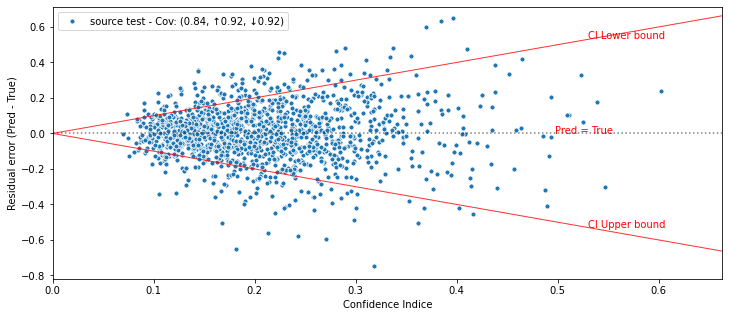

In [31]:
plot_confidence_v2(y_test, y_test_pred , y_test_pred-2*stds_test,  y_test_pred+2*stds_test, label='source test')

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

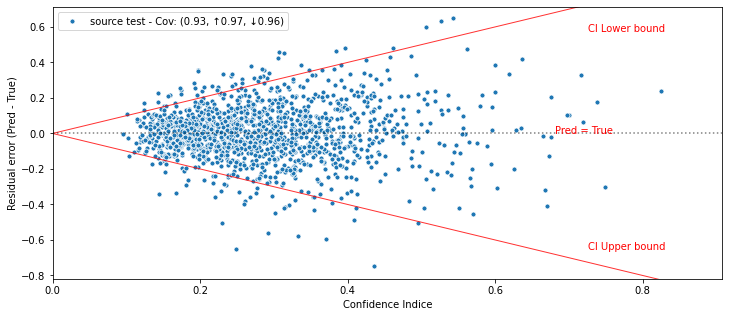

In [30]:
plot_confidence_v2(y_test, y_test_pred , y_test_pred-2*new_stds,  y_test_pred+2*new_stds, label='source test')

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

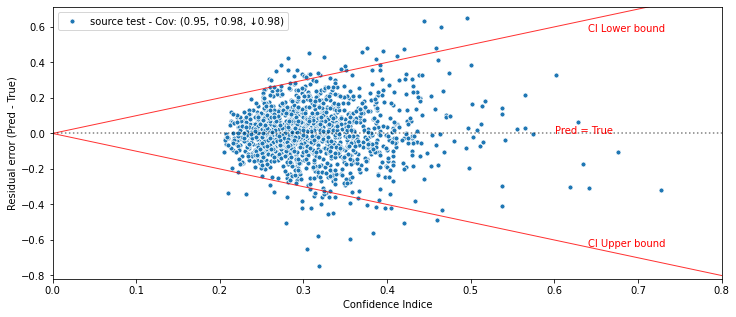

In [23]:
plot_confidence_v2(y_test, y_test_pred, y_test_q05, y_test_q95, label='source test')

In [17]:
table_results(y_test, y_test_pred, [y_test_q05, y_test_q95], thresholds=model[-1].thresholds_, show_both=True)

,Mean Residual,Coverage,Mean Confidence Indice,Threshold,% Data Below Threshold
Down,0.114116,0.980583,0.264261,0.305291,0.633630
Up,0.114116,0.980993,0.269941,0.321178,0.647300
Both,0.089634,0.970213,0.264057,NaN,0.481887


In [52]:
all_metrics = uct.metrics.get_all_metrics(np.array(y_test_pred), np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.115
  RMSE          0.154
  MDAE          0.084
  MARPD         1.449
  R2            0.982
  Correlation   0.991
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.012
  Mean-absolute Calibration Error       0.010
  Miscalibration Area                   0.010
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.041
     Group Size: 0.56 -- Calibration Error: 0.016
     Group Size: 1.00 -- Calibration Error: 0.010
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.054
     Group Size: 0.56 -- Calibration Error: 0.020
     Group Size: 1.00 -- Calibration Error: 0.012
================

<AxesSubplot:title={'center':'Sharpness'}, xlabel='Predicted Standard Deviation', ylabel='Normalized Frequency'>

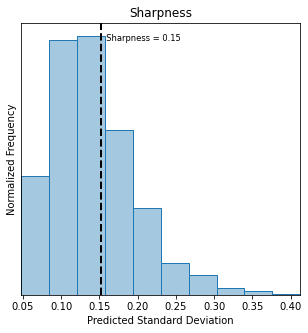

In [34]:
uct.plot_sharpness(new_stds)

<AxesSubplot:title={'center':'Adversarial Group Calibration'}, xlabel='Group size', ylabel='Calibration Error of Worst Group'>

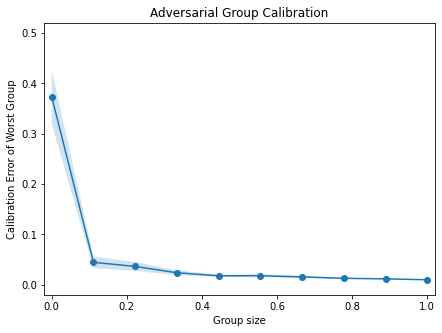

In [42]:
uct.plot_adversarial_group_calibration(np.array(y_test_pred), np.array(new_stds), np.array(y_test))

<AxesSubplot:title={'center':'Ordered Prediction Intervals'}, xlabel='Index (Ordered by Observed Value)', ylabel='Predicted Values and Intervals'>

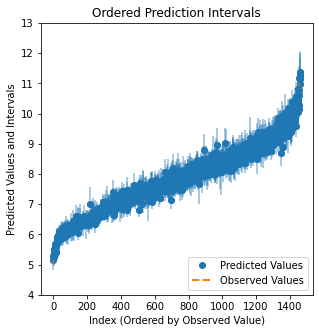

In [44]:
uct.plot_intervals_ordered(np.array(y_test_pred), np.array(new_stds), np.array(y_test))

<AxesSubplot:title={'center':'Prediction Intervals'}, xlabel='Observed Values', ylabel='Predicted Values and Intervals'>

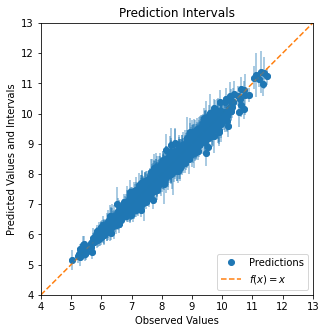

In [45]:
uct.plot_intervals(np.array(y_test_pred), np.array(new_stds), np.array(y_test))

In [54]:
Bagging_metrics = {}

In [89]:
all_metrics

{'accuracy': {'mae': 0.11462773275874187,
  'rmse': 0.15388806572662228,
  'mdae': 0.0836900329589847,
  'marpd': 1.448890527336888,
  'r2': 0.9819075452331835,
  'corr': 0.9909214836564907},
 'avg_calibration': {'rms_cal': 0.012265058453502018,
  'ma_cal': 0.00986861092124251,
  'miscal_area': 0.009939556141841896},
 'adv_group_calibration': {'ma_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
          0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
   'adv_group_cali_mean': array([0.37933333, 0.04052909, 0.02953638, 0.02420504, 0.01885051,
          0.01622405, 0.01592308, 0.01311295, 0.01157909, 0.00986861]),
   'adv_group_cali_stderr': array([0.04499084, 0.00947313, 0.00433484, 0.00483517, 0.00233052,
          0.00197311, 0.00159849, 0.00069938, 0.00039108, 0.        ])},
  'rms_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
          0.55555556, 0.66666667, 0.7777

### Save Metrics

In [92]:
import pickle

In [93]:
with open('Bagging_metrics_dense.pkl', 'wb') as f:
    pickle.dump(all_metrics, f)
        

In [90]:
for x in all_metrics:
    print (x)
    for y in all_metrics[x]:
        print (y,':',all_metrics[x][y])

accuracy
mae : 0.11462773275874187
rmse : 0.15388806572662228
mdae : 0.0836900329589847
marpd : 1.448890527336888
r2 : 0.9819075452331835
corr : 0.9909214836564907
avg_calibration
rms_cal : 0.012265058453502018
ma_cal : 0.00986861092124251
miscal_area : 0.009939556141841896
adv_group_calibration
ma_adv_group_cal : {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]), 'adv_group_cali_mean': array([0.37933333, 0.04052909, 0.02953638, 0.02420504, 0.01885051,
       0.01622405, 0.01592308, 0.01311295, 0.01157909, 0.00986861]), 'adv_group_cali_stderr': array([0.04499084, 0.00947313, 0.00433484, 0.00483517, 0.00233052,
       0.00197311, 0.00159849, 0.00069938, 0.00039108, 0.        ])}
rms_adv_group_cal : {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]), 'adv_group_cali_mean': array([0.4505096 